In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The first step in preprocessing the data is ordering, of which there are a few different methods to consider. Credit card transactions have a temporal nature to them, so what should be considered an outlier is determined by that credit card's *history* and not just the transaction itself. As such, the data cannot be randomized before preprocessing is complete. The first potential ordering technique would be to use the transaction number, which *should* be ordinal. However, in a real world scenario, there could be some lag between different locations, or potential duplicates, or the transaction number could be non-ordinal in nature. Due to these possibilities, it is much safer to order by time, which is especially useful for temporal-window calculations.

In [3]:
data = pd.read_csv("../data/fraud_records.csv")
data = data.rename(columns={"Unnamed: 0": "index"})
data["trx_date"] = pd.to_datetime(data["trans_date"] + " " + data["trans_time"])
data = data.sort_values(by="trx_date")
data.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trx_date
691900,580-68-3116,6011074988495916,Sarah,Price,F,33146 Butler Spur,Asheville,NC,28804,35.6374,...,2021-01-01,00:00:09,1609477209,gas_transport,18.24,0,fraud_Erdman-Kertzmann,35.618149,-81.838896,2021-01-01 00:00:09
754418,565-01-8042,4500645580486,Carolyn,Stafford,F,8286 Michael Key,Rapid City,SD,57701,44.1415,...,2021-01-01,00:00:16,1609477216,gas_transport,7.42,0,fraud_Cummings LLC,44.743537,-102.858857,2021-01-01 00:00:16
2446544,205-73-5783,347208496498560,Allen,White,M,2531 Diane Landing Apt. 510,Hernando,MS,38632,34.8096,...,2021-01-01,00:00:51,1609477251,gas_transport,82.07,0,"fraud_Christiansen, Goyette and Schamberger",34.546811,-89.034166,2021-01-01 00:00:51
1388156,216-31-5543,3520509530727721,Joseph,Mann,M,6958 Brown Stravenue,Alexandria,MN,56308,45.8817,...,2021-01-01,00:01:07,1609477267,gas_transport,43.03,0,fraud_Koss and Sons,45.359075,-95.103701,2021-01-01 00:01:07
1475370,700-23-7718,5191043006848665,Mia,Miller,F,1418 Terri Drives,Mobile,AL,36693,30.6311,...,2021-01-01,00:01:07,1609477267,gas_transport,80.40,0,"fraud_Streich, Hansen and Veum",29.774038,-87.201806,2021-01-01 00:01:07


Most of the features that will prove useful are *rolling* features: quantities which are calculated using the most recent points, but ignoring the earliest data. This is crucial for a two reasons. The first being that for real, non-fraudulent customers, things change. People move, get new jobs, and change their habits. Therefore considerable changes in a person's spending location, spending amount, and spending time of day are not necessarily indicative of fraud. While such a change might set off some alarms in the fraud-detection system initially (which is a good thing), the features should adapt so that the earlier habits are no longer reflected after some time.

That said, their are a few features that are trivial to calculate and do not rely on windowing techniques, the first of which is "timedelta". This feature is fairly intuitive, as customers will only use their cards so often. If a string of purchases happens with little time in between, that could be a strong indication of fraud. Or, on the other end, a card that hasn't been used in months suddenly being used for a purchase can be considered suspicious. 

Another temporal component is the time of day, "time". The "unix_time" is not an especially informative quantity, because it is strictly ordinal whereas human life is periodic. Therefore, we bin it into days, and the time represents the time in seconds since midnight. A third, and very similar feature is the day of the week that the transaction occured. If a person does most of their shopping on saturdays, then a series of purchases on a tuesday is unlikely.

The final global quantity to calculate is what fraction of purchases are used on each merchant category. This set of features is global becuase people tend to have things in common. Most people will buy food, gas, clothes, etc. at comparable frequencies. Additionally, the rolling calculations have one fatal flaw: the first windows calculations will make little sense as they won't have the full window of data. These features will add some stability to that.

In [4]:
# global features

# time since last transaction
data["timedelta"] = data.groupby(by="cc_num", group_keys=True)["unix_time"].transform(
    lambda x: x - x.min()
)

# time of day in seconds
data["time"] = data["unix_time"].transform(lambda x: x % 60 * 60 * 24)

# day of week
data["weekday"] = data.groupby(by="cc_num", group_keys=True)["unix_time"].transform(
    lambda x: (x % 60 * 60 * 24 * 7) // (60 * 60 * 24)
)

# total purchases per merchant type
trx_category = pd.get_dummies(data[["cc_num", "category"]], columns=["category"])
tot_purchases_per_category = trx_category.groupby(by="cc_num", group_keys=True).cumsum()

frac_purchases_per_category = tot_purchases_per_category.div(
    tot_purchases_per_category.sum(axis=1), axis=0
)

cols = {col: col + "_fraction" for col in frac_purchases_per_category.columns}
frac_purchases_per_category = frac_purchases_per_category.rename(columns=cols)

## The von Mises Distribution

It is usually a good assumption that any given feature will be distributed normally given a large enough sample. This is a very poor assumption if a feature is periodic (like clock time) or literally circular (like longitude and latitude). The default distribution for features like this is the [von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution), which is often called the "periodic normal distribution" and can be thought of normal curve wrapped around a circle. The equation for the distribution is 

$$
    \rho(x | \mu, \kappa) = \frac{e^{\kappa \cos(x- \mu)}}{2 \pi I_0(\kappa)},
$$

where $I_0$ is the modified Bessel funtion of the first kind of order zero. $\mu$ is the circular mean, and $\kappa$ is a quantity comparable to the varainace. $\kappa$ turns out to be non-trivial to calculate, so instead the circular varaince will be calculated during windowing operations, which can later be used to calculate $\kappa$.

The circular mean and variance are interpreted as follows: given a set of angles, calculate their position on the surface of a circle. The sum of all of these positions yields the average position, which when inverted using an arctangent function will yield the average angle. Similarly, one minus the magnitude of this average position yields the circular variance. The functions to calculate the the circular quantities are given below.

Luckily, $\kappa$ has an exact relationship with the circular variance. This luck runs out *immediately*, as that relationship is

$$
\text{cVar(x)} = 1 - \frac{I_1(\kappa)}{I_0(\kappa)},
$$

which, given the nature of the Bessel functions, is not invertible to find $\kappa$ exactly, but can be approximated. Using a third order Taylor polynomial, this statement is approximately equal to

$$
\text{cVar(x)} = 1 + \frac{\kappa}{2} - \frac{\kappa^3}{16} + O(\kappa^5),
$$

of which we can take the principle root of to get the value of $\kappa$. 

In [5]:
def circular_mean(x, period):
    circ_dist = np.exp(1j * x / period)
    net = np.sum(circ_dist)

    return np.arctan2(net.imag, net.real)


def circular_var(x, period):
    circ_dist = np.exp(1j * x / period)
    net = np.sum(circ_dist)
    r = np.abs(net) / len(circ_dist)

    return 1 - r

The first group of rolling features will be based on number of transactions, and will include:

* circular mean and variance of the longitude and latitude as well as the longitude and latitude of the merchant
* circular mean and variance of the time and weekday
* fractional purchase frequencies per merhcant category

In [6]:
def window_aggregate(data, window=10):
    # the period in seconds of a day
    day = 60 * 60 * 24

    # the period conversion from degrees to radians
    degrees = 180 / np.pi

    # average position
    avg_long = (
        data.groupby(by="cc_num", group_keys=True)[
            "long"
        ]  # data is grouped by credit card number
        .rolling(
            window=window, min_periods=0
        )  # then the rolling window calculates the mean
        .apply(circular_mean, kwargs={"period": degrees})
    )

    avg_long = pd.Series(avg_long.values, index=avg_long.index.get_level_values(1))

    data[f"avg_long_rolling_{window}"] = avg_long

    avg_lat = (
        data.groupby(by="cc_num", group_keys=True)["lat"]
        .rolling(window=window, min_periods=0)
        .apply(circular_mean, kwargs={"period": degrees})
    )
    # arctan2 returns -pi to pi
    # latitude is defined -pi / 2 to pi / 2
    # therefore we divide by two
    avg_lat = pd.Series(avg_lat.values / 2.0, index=avg_lat.index.get_level_values(1))

    data[f"avg_lat_rolling_{window}"] = avg_lat

    # position variance
    var_long = (
        data.groupby(by="cc_num", group_keys=True)["long"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    var_long = pd.Series(var_long.values, index=var_long.index.get_level_values(1))

    data[f"var_long_rolling_{window}"] = var_long

    var_lat = (
        data.groupby(by="cc_num", group_keys=True)["lat"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    var_lat = pd.Series(var_lat.values, index=var_lat.index.get_level_values(1))

    data[f"var_lat_rolling_{window}"] = var_lat

    # position mean and variance for merchant position
    avg_merch_long = (
        data.groupby(by="cc_num", group_keys=True)["merch_long"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    avg_merch_long = pd.Series(
        avg_merch_long.values, index=avg_merch_long.index.get_level_values(1)
    )

    data[f"avg_merch_long_rolling_{window}"] = avg_merch_long

    avg_merch_lat = (
        data.groupby(by="cc_num", group_keys=True)["merch_lat"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    avg_merch_lat = pd.Series(
        avg_merch_lat.values, index=avg_merch_lat.index.get_level_values(1)
    )

    data[f"avg_merch_lat_rolling_{window}"] = avg_merch_lat

    var_merch_long = (
        data.groupby(by="cc_num", group_keys=True)["merch_long"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    var_merch_long = pd.Series(
        var_merch_long.values, index=var_merch_long.index.get_level_values(1)
    )

    data[f"var_merch_long_rolling_{window}"] = var_merch_long

    var_merch_lat = (
        data.groupby(by="cc_num", group_keys=True)["merch_lat"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": degrees})
    )

    var_merch_lat = pd.Series(
        var_merch_lat.values, index=var_merch_lat.index.get_level_values(1)
    )

    data[f"var_merch_lat_rolling_{window}"] = var_merch_lat

    # average and variance of transaction time of day
    avg_time = (
        data.groupby(by="cc_num", group_keys=True)["unix_time"]
        .rolling(window=window, min_periods=0)
        .apply(circular_mean, kwargs={"period": day})
    )

    avg_time = pd.Series(avg_time.values, index=avg_time.index.get_level_values(1))

    data[f"avg_time_rolling_{window}"] = avg_time

    var_time = (
        data.groupby(by="cc_num", group_keys=True)["unix_time"]
        .rolling(window=window, min_periods=0)
        .apply(circular_var, kwargs={"period": day})
    )

    var_time = pd.Series(var_time.values, index=var_time.index.get_level_values(1))

    data[f"var_time_rolling_{window}"] = var_time

    # average and variance of weekday
    avg_weekday = (
        data.groupby(by="cc_num", group_keys=True)["weekday"]
        .rolling(window=window, min_periods=0)
        .apply(circular_mean, kwargs={"period": 7.0})
    )

    avg_weekday = pd.Series(
        avg_weekday.values, index=avg_weekday.index.get_level_values(1)
    )

    data[f"avg_weekday_rolling_{window}"] = avg_weekday

    var_weekday = (
        data.groupby(by="cc_num", group_keys=True)["weekday"]
        .rolling(window=window, min_periods=0)
        .apply(circular_mean, kwargs={"period": 7.0})
    )

    var_weekday = pd.Series(
        var_weekday.values, index=var_weekday.index.get_level_values(1)
    )

    data[f"var_weekday_rolling_{window}"] = var_weekday

    # calculate fractional percentage of purchase types over the window
    trx_category = pd.get_dummies(data[["cc_num", "category"]], columns=["category"])
    rolling_purchases_per_category = (
        trx_category.groupby(by="cc_num", group_keys=True)
        .rolling(window=window, min_periods=0)
        .sum()
    )

    rolling_frac_purchases_per_category = rolling_purchases_per_category.div(
        rolling_purchases_per_category.sum(axis=1), axis=0
    )

    cols = {
        col: col + f"_fraction_rolling_{window}"
        for col in rolling_frac_purchases_per_category.columns
    }
    rolling_frac_purchases_per_category = rolling_frac_purchases_per_category.rename(
        columns=cols
    )

    rolling_frac_purchases_per_category = rolling_frac_purchases_per_category.set_index(
        rolling_frac_purchases_per_category.index.get_level_values(1)
    )

    data = pd.concat([data, rolling_frac_purchases_per_category], join="inner", axis=1)

    return data

The second batch of rolling features is based on time, and will include:
* the average amount spent per transaction in the last 30 days
* the average amount spent per day in the last 30 days
* the amount spent so far on that given day

In [7]:
def time_window_aggregate(data):
    # features inspired by
    # https://www.semanticscholar.org/paper/Data-mining-for-credit-card-fraud%3A-A-comparative-Bhattacharyya-Jha/9d26f0ba02ee5efe9b9c7bdcb5f528c8b8253cf7?p2df

    # for each entry, get past 30 days
    # calculate average amount spent per transaction
    thirty_days = pd.Timedelta(
        days=30
    )  # a 30 day time delta object for temporal windowing
    per_day_grouper = pd.Grouper(
        key="trx_date", axis=0, freq="1D"
    )  # groups transactions that occured on the same day

    avg_amt = (
        data.groupby(by="cc_num", group_keys=True, sort="trx_date")[
            ["trx_date", "amt"]
        ]  # data is grouped by card number
        .rolling(
            window=thirty_days, min_periods=0, on="trx_date"
        )  # then the mean is calculated over thirty day windows
        .mean()
    )

    thirty_day_average_amt = pd.Series(
        avg_amt["amt"].values, index=avg_amt.index.get_level_values(1)
    )

    data[f"thirty_day_avg_amt"] = thirty_day_average_amt

    # calculate total spent so far on given day
    # data is grouped first by card number
    # then grouped by date
    # the cumulative amount spent is then calculated for each transaction for that day
    day_spent = data.groupby(by=["cc_num", per_day_grouper], group_keys=True)[
        "amt"
    ].cumsum()

    data["total_daily_amount"] = day_spent

    # calculate total number of transactions so far on given day
    day_trx = data.groupby(by=["cc_num", per_day_grouper], group_keys=True)[
        "amt"
    ].cumcount()

    data["total_daily_transactions"] = day_trx + 1

    return data

The temporal-windowing technique makes use of human-timescales (days and months only, because weeks proved to be too calculation-intensive to meet the deadline of this project), but there is little intuition for how long ten transactions might span, which also likely varies highly from user to user. Therefore, three different window lengths are used for the transaction-windowing function: 10, 50, and 100 transactions. The 10-transaction window features will be the most sensitive to change, and the 100-window the least, but the relationships between these features can be potentially learned by the model. 

In [8]:
windows = [10, 50, 100]
for window in windows:
    data = window_aggregate(data, window)
    # partial progress is saved in case of crashes
    data.to_csv(f"../data/data_partial_{window}.csv")

data = time_window_aggregate(data)

## Probability calculations

One of the more common methods of anomaly detection is simply identifying outliers and flagging them for manual inspection. To do this, the probability of each point in the dataset (or more likely, the probability density) is calculated along with Z-scores or any other scoring method that may be appropriate. This calculation is simple, and only requires the normal or von Mises probability density to be calculated for each feature and then their product is aggregated as the pdf evaluated at that point.

In [9]:
def von_mises_kappa_approx(var):
    # solution to the cubic approximation
    # of the ratio of the first two modified bessel functions
    # of the first kind
    # var = 1 - I_1(k) / I_0(k)
    # -> 0 ~ k^3 / 16 - k / 2 + (1 - var)

    a = 1 / 16.0
    b = 0
    c = -1 / 2.0
    d = 1 - var

    roots = np.roots([a, b, c, d])

    # the principal root will always have an imaginary part of zero
    # but +0j will mess up further calculations
    return roots[0].real


def von_mises_density(x, mu, kappa):
    p = np.exp(kappa * np.cos(x - mu)) / (2 * np.pi * np.i0(kappa))

    return p


def normal_density(x, mu, var):
    p = (1 / np.sqrt(2 * np.pi * var)) * np.exp((-1.0 / (2 * var)) * x**2)

    return p


def probability_density(data):
    data["probability_density"] = 0.0
    epsilon = np.finfo(np.float64).tiny
    # the following features have von mises distributions
    von_mises_features = ["long", "lat", "time", "weekday", "merch_long", "merch_lat"]
    windows = [10, 50, 100]
    for vmf in von_mises_features:
        for window in windows:
            col_base = (
                f"{vmf}_rolling_{window}"  # the base name of the columns is created
            )
            mu = "avg_" + col_base  # mean column name
            var = "var_" + col_base  # variance column name
            kappa = data[var].apply(von_mises_kappa_approx)  # kappa is approximated
            vmd = von_mises_density(
                data[vmf], data[mu], kappa
            )  # the von mises density is calculated
            data["probability_density"] += np.log(
                epsilon + vmd
            )  # the probability for the point is aggregated

    # the following features have normal distributions
    normal_features = [
        "category_entertainment_fraction",
        "category_food_dining_fraction",
        "category_gas_transport_fraction",
        "category_grocery_net_fraction",
        "category_grocery_pos_fraction",
        "category_health_fitness_fraction",
        "category_home_fraction",
        "category_kids_pets_fraction",
        "category_misc_net_fraction",
        "category_misc_pos_fraction",
        "category_personal_care_fraction",
        "category_shopping_net_fraction",
        "category_shopping_pos_fraction",
        "category_travel_fraction",
        "thirty_day_avg_amt",
        "total_daily_amount",
        "total_daily_transactions",
    ]

    for nf in normal_features:
        if "category" in nf:
            try:
                for window in windows:
                    col = f"{nf}_rolling_{window}"
                    mu = data[col].mean()
                    var = data[col].var()
                    nd = normal_density(data[col], mu, var)
                    data["probability_density"] += np.log(epsilon + nd)
            except:
                pass
        else:
            mu = data[nf].mean()
            var = data[nf].var()
            nd = normal_density(data[nf], mu, var)
            data["probability_density"] += np.log(epsilon + nd)

    return data


# globe coordinates are converted to radians to match the output of arctan
data["long"] = data["long"] * np.pi / 180.0
data["lat"] = data["lat"] * np.pi / 180.0
data["merch_long"] = data["merch_long"] * np.pi / 180.0
data["merch_lat"] = data["merch_lat"] * np.pi / 180.0

# probability density column is calculated
data = probability_density(data)
data["probability_density"] = np.exp(data["probability_density"])
# z scores for all points are calculated
data["z"] = (data["probability_density"] - data["probability_density"].mean()) / data[
    "probability_density"
].std()

Text(0.5, 0, 'Z-Score')

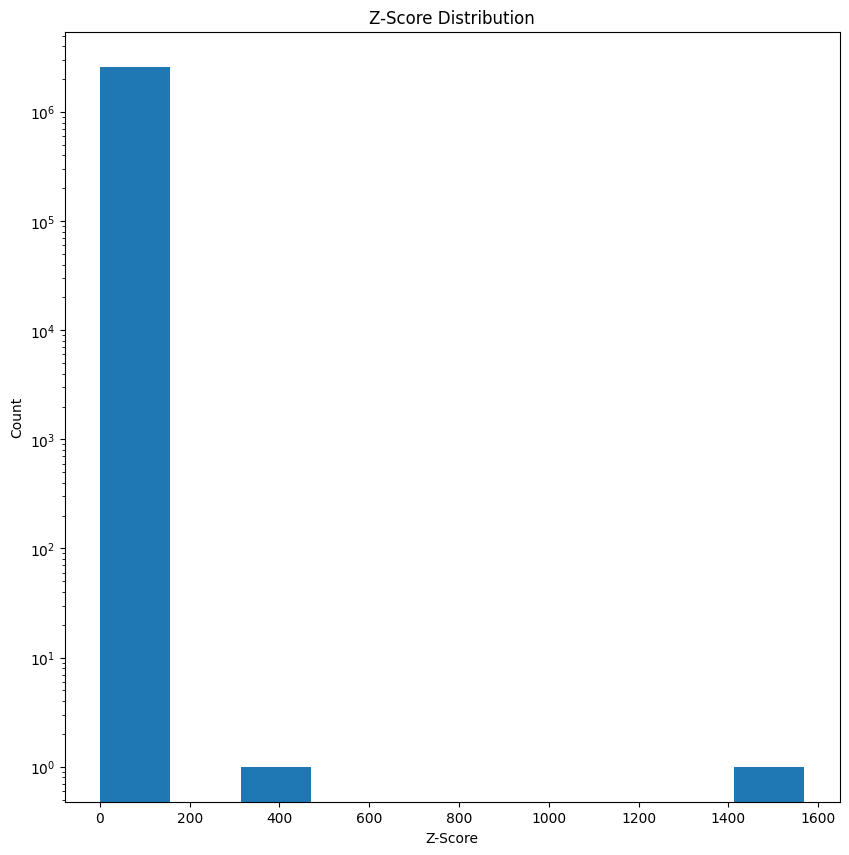

In [10]:
# distribution plot of fraud and not fraud
fig, axs = plt.subplots(figsize=(10, 10))

axs.hist(data["z"])
axs.set_title("Z-Score Distribution")
axs.set_yscale("log")
axs.set_ylabel("Count")
axs.set_xlabel("Z-Score")

The distribution of Z-scores for this dataset has proved to be quite useless, as almost all points have the same or extremely similar z-scores with a few outlandish exceptions. This comes from one of two places: events which have zero probability due to zero variance in the window, and events which have a probability underflow due to the product of unlikely features. This is indicative of a fatal flaw, either in calculation, approach, or simulation. If it is a flaw in my calculation, I have not been able to identify it at this time. All values have extremely small probability densities associated with them, but this is intuitive to me, as mixes of rural of urban credit card users who are spread throughout the country are mixed together. In that scope, all transactions are unlikely, and the goal was to identify which are the least likely. 

If the flaw is in the simulation, then this outcome was inevitable. However, given the fact that the generation process uses a Markov chain, the points should be normally distributed, so this calculated distribution is highly unlikely.

The most likely reason for this distribution is that my windowing techniques led to some strange distributions of features. For example, windows of only a few points that are nearly identical would lead to nearly zero variance for that window, which would lead to extremely small probability densities on its own. This flaw would then be applied multiplicativey from dozens of features, leading to a nonsensical distribution. I attempted to rectify this by taking the sum of the logarithm of the pdf, but due to the presence of zero probability densities for some points, this would output an infinite value. I added a stability parameter $\epsilon$ within the logarithm to allow the calculation to pass, but this would cause the same issue of all extremely small probabilities being mapped to $\Sigma\log\epsilon$, which doesn't solve the problem. 

That said, my approach was designed with supervised learning in mind, so this distribution (while concerning) doesn't necessarily imply that this feature set is not viable. However, with little time to look into these issues, I must conclude that statistical anomaly detection is not an appropriate approach to the constructed dataset.

In [11]:
# drop irrelevant columns
to_drop = [
    "trans_date",
    "trans_time",
    "cc_num",
    "merchant",
    "category",
    "first",
    "last",
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "city_pop",
    "job",
    "dob",
    "trans_num",
    "unix_time",
    "trx_date",
    "profile",
    "acct_num",
    "ssn",
]

data = data.drop(columns=to_drop)

In [12]:
data.to_csv("../data/preprocessed_data.csv", index=False)